### 1. Library

In [3]:
import os
import re
import random
import sys
import shutil

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.notebook import tqdm
from tqdm.notebook import tqdm_notebook

import tensorflow as tf
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.utils import shuffle


from keras.preprocessing import image

In [5]:
import time

time_start = time.time()

def sec_to_time(seconds):
    days = seconds // (60 * 60 * 24)
    seconds -= days * (60 * 60 * 24)
    hours = seconds // (60 * 60)
    seconds -= hours * (60 * 60)
    minutes = seconds // 60
    seconds -= minutes * 60
    return f"{int(days)}:{int(hours):02}:{int(minutes):02}:{int(seconds):02}"

### 2. Load Dataset

In [6]:
color_dataset_dir = 'Dataset'
gray_dataset_dir = 'Output Grayscale'

In [7]:
def read_directory(dir_a, dir_b):
    list_path_color_images = []
    list_path_gray_images = []
    list_name = []
    
    for root, dirs, files in os.walk(dir_a):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
                list_path_color_images.append(root+'/'+file)
                list_name.append(re.split(' |_', file)[0].lower())
                
    for root, dirs, files in os.walk(dir_b):
        for file in files:
            if (file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png')):
                list_path_gray_images.append(root+'/'+file)
    
    df = pd.DataFrame({
        'ulos_type': list_name,
        'path_color': list_path_color_images,
        'path_gray': list_path_gray_images
    })
    
    return df

In [8]:
df = read_directory(color_dataset_dir, gray_dataset_dir)
display(df.head())

,ulos_type,path_color,path_gray
0,harungguan,Dataset\harungguan/Harungguan Biru_Ruth Theres...,Output Grayscale\harungguan/Harungguan Biru_Ru...
1,harungguan,Dataset\harungguan/Harungguan Coklat Terang_Ru...,Output Grayscale\harungguan/Harungguan Coklat ...
2,harungguan,Dataset\harungguan/Harungguan Hijau_Ruth There...,Output Grayscale\harungguan/Harungguan Hijau_R...
3,harungguan,Dataset\harungguan/Harungguan Merah_Ruth There...,Output Grayscale\harungguan/Harungguan Merah_R...
4,harungguan,Dataset\harungguan/Harungguan Orange_Ruth Ther...,Output Grayscale\harungguan/Harungguan Orange_...


### 3. Preprocessing

In [9]:
def image_resize(original_image, w = 360, h = 900):
    shrinked_image = cv2.resize(original_image, (w, h),
                                interpolation = cv2.INTER_AREA)
    
    # DEBUG
    # plt.imshow(shrinked_image)
    # plt.axis("off")
    # plt.show()

    return shrinked_image

In [10]:
def image_quantization(original_image, n_clusters = 12):
    # flatten image
    reshaped_image = np.reshape(original_image,
                                ((original_image.shape[0] * original_image.shape[1]), 3))

    model = KMeans(n_clusters=n_clusters)
    target = model.fit_predict(reshaped_image)
    color_space = model.cluster_centers_
    
    output_image = np.reshape(color_space.astype("uint8")[target],
                              (original_image.shape[0],
                               original_image.shape[1], 3))
    
    quantized_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2Lab)

    # DEBUG
    # plt.imshow(quantized_image)
    # plt.axis("off")
    # plt.show()
    
    return quantized_image

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


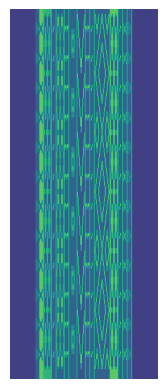

In [11]:
for i in df.itertuples():
    color_image = cv2.imread(i.path_color)
    gray_image = cv2.imread(i.path_gray)
    
    # preprocessing
    color_image = image_resize(color_image)
    color_image = image_quantization(color_image)
    
    gray_image = image_resize(gray_image)
    gray_image = image_quantization(gray_image)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_Lab2RGB)
    gray_image = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)

    # DEBUG
    plt.imshow(gray_image)
    plt.axis("off")
    plt.show()
    
    # another process ...
    break


In [13]:
# KODE INI KAMI GUNAKAN UNTUK MENYAMAKAN RATIO (DALAM KONTEKS GAMBAR YANG DIINPUT SAAT MENJALANKAN MODEL JIKA RATIO GAMBAR TIDAK SAMA SEPERTI DI TRAINING)

aspect_ratio = 16 / 9

def calculate_resolution(width, aspect_ratio):
    new_width = width
    new_height = int(width / aspect_ratio)
    return (new_width, new_height)

RESHAPE = calculate_resolution(256, aspect_ratio)

def preprocess_image(cv_img):
    # Resize image
    cv_img = cv2.resize(cv_img, RESHAPE)
    
    # Convert color space to Lab
    lab_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2LAB)
    
    # Flatten image for KMeans clustering
    flattened_img = lab_img.reshape((-1, 3))
    
    # Perform color quantization using KMeans clustering
    kmeans = KMeans(n_clusters=8)
    kmeans.fit(flattened_img)
    quantized_colors = kmeans.cluster_centers_.astype(np.uint8)
    labels = kmeans.labels_
    quantized_img = quantized_colors[labels].reshape(RESHAPE[1], RESHAPE[0], 3)
    
    # Normalize pixel values to the range [-1, 1]
    normalized_img = (quantized_img.astype(float32) - 127.5) / 127.5
    
    return normalized_img

In [14]:
df

,ulos_type,path_color,path_gray
0,harungguan,Dataset\harungguan/Harungguan Biru_Ruth Theres...,Output Grayscale\harungguan/Harungguan Biru_Ru...
1,harungguan,Dataset\harungguan/Harungguan Coklat Terang_Ru...,Output Grayscale\harungguan/Harungguan Coklat ...
2,harungguan,Dataset\harungguan/Harungguan Hijau_Ruth There...,Output Grayscale\harungguan/Harungguan Hijau_R...
3,harungguan,Dataset\harungguan/Harungguan Merah_Ruth There...,Output Grayscale\harungguan/Harungguan Merah_R...
4,harungguan,Dataset\harungguan/Harungguan Orange_Ruth Ther...,Output Grayscale\harungguan/Harungguan Orange_...
...,...,...,...
59,sadum,Dataset\sadum/sadum_sri-rahayu_010.png,Output Grayscale\sadum/sadum_sri-rahayu_010.png
60,sadum,Dataset\sadum/Sadum_Theresia-Yolanda_001.png,Output Grayscale\sadum/Sadum_Theresia-Yolanda_...
61,sadum,Dataset\sadum/Sadum_Theresia-Yolanda_002.png,Output Grayscale\sadum/Sadum_Theresia-Yolanda_...
62,sadum,Dataset\sadum/Sadum_Theresia-Yolanda_003.png,Output Grayscale\sadum/Sadum_Theresia-Yolanda_...


In [15]:
# KODE HASIL GRAYSCALE DIGABUNG DENGAN GAMBAR ASLI

def convert_to_grayscale(input_folder, output_folder):
    # Membuat folder output jika belum ada
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Membuat daftar sub-folder di dalam folder input
    sub_folders = os.listdir(input_folder)
    
    # Iterasi melalui setiap sub-folder
    for sub_folder in sub_folders:
        # Membuat path lengkap ke sub-folder
        sub_folder_path = os.path.join(input_folder, sub_folder)
        
        # Memeriksa apakah itu adalah direktori
        if not os.path.isdir(sub_folder_path):
            print(f"{sub_folder_path} bukan direktori. Dilewati.")
            continue
        
        # Membuat folder output untuk setiap kategori
        output_sub_folder = os.path.join(output_folder, sub_folder)
        if not os.path.exists(output_sub_folder):
            os.makedirs(output_sub_folder)
        
        # Membuat daftar file dalam sub-folder
        image_files = os.listdir(sub_folder_path)
        
        # Iterasi melalui setiap file gambar dalam sub-folder
        for image_file in image_files:
            img_path = os.path.join(sub_folder_path, image_file)
            
            # Membaca gambar
            img = cv2.imread(img_path)
            
            # Cek apakah gambar berhasil dibaca
            if img is None:
                print(f"Gagal membaca gambar: {image_file}")
                continue
            
            # Salin gambar asli ke dalam folder output
            output_original_path = os.path.join(output_sub_folder, image_file)
            shutil.copy(img_path, output_original_path)
            
            # Konversi ke grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Menyusun path lengkap dari output file untuk gambar grayscale
            output_gray_path = os.path.join(output_sub_folder, f"gray_{image_file}")
            
            # Menyimpan gambar grayscale
            cv2.imwrite(output_gray_path, gray_img)

# Direktori dataset
dataset_dir = "Dataset"

# Direktori untuk menyimpan gambar grayscale
output_folder = "Dataset_with_Grayscale"

# Menyusun path lengkap dari output folder
output_path = output_folder

convert_to_grayscale(dataset_dir, output_path)

In [16]:
# PERBAIKAN KODE JIKA SESUAI DENGAN PENGUBAHAN RATIO

def preprocess_batch_from_aug(imgs):
    final_imgs = np.zeros_like(imgs)
    
    for i in range(len(imgs)):
        final_img = preprocess_image(imgs[i]) 
        final_imgs[i] = final_img 
        
    l_imgs = final_imgs[:,:,:,0]
    l_imgs = np.expand_dims(l_imgs, axis=3)
    ab_imgs = final_imgs[:,:,:,1:]
    return l_imgs, ab_imgs

In [17]:
# RESHAPE = (int(1440/4), int(3600/4))
RESHAPE = (256, 256)

def preprocess_image(cv_img):
    cv_img = cv2.resize(cv_img, RESHAPE)
    img = (cv_img - 127.5) / 127.5
    return img

def deprocess_image(img):
    img = (img * 127.5) + 127.5
    return img.astype('uint8')

In [18]:
def preprocess_batch_from_aug(imgs):
    final_imgs = np.zeros((imgs.shape))
    
    imgs = imgs.astype(np.uint8)
    
    for i in range(len(imgs)):
        final_img = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2LAB)
        final_img = preprocess_image(final_img) 
        final_imgs[i] = final_img 
        
    l_imgs = final_imgs[:,:,:,0]
    l_imgs = np.expand_dims(l_imgs, axis=3)
    ab_imgs = final_imgs[:,:,:,1:]
    return l_imgs, ab_imgs

In [19]:
def is_an_image_file(filename):
    IMAGE_EXTENSIONS = ['.png', '.jpg', '.jpeg']
    for ext in IMAGE_EXTENSIONS:
        if ext in filename:
            return True
    return False
    
def list_image_files(base_path):
    directory_generator = os.walk(base_path)
    next(directory_generator)
    path_tree = {}
    for root_path, directories, files in directory_generator:
        path_tree[os.path.basename(root_path)] = [
            os.path.join(root_path, file_path) for file_path in files]
    return sum(list(path_tree.values()), [])

In [20]:
def load_image(path):
    img = cv2.imread(path[0])
    
    # Make sure all images are 256 x 256 by cropping them
    r, c = img.shape[:2]
    r_diff = (r - 256) // 2
    c_diff = (c - 256) // 2
    cropped = img[r_diff:256 + r_diff, c_diff:256 + c_diff]
    return cropped
    # return img

def load_images(path, n_images=-1):
    all_image_paths = list_image_files(path)
    
    if n_images < 0:
        n_images = len(all_image_paths)
    images_l, images_ab = [], []
    
    # Initialize a progress bar with max of n_images
    pbar = tqdm(total = n_images, desc = "Loading Images...")
    
    for path in zip(all_image_paths):
        img = load_image(path)
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab_img = preprocess_image(lab_img)
        
        l = lab_img[:,:,0]
        l = l[:,:,np.newaxis]
        # Include all 3 channels, overwrite 1st channel with 0's
        ab = lab_img[:,:,1:]

        images_l.append(l)
        images_ab.append(ab)

        images_loaded = len(images_l)
        
        # Increase progress by one
        pbar.update(1)
        
        if images_loaded > n_images - 1: 
            break

    return {
        'l': np.array(images_l),
        'ab': np.array(images_ab)
    }

In [21]:
# def load_images(df):
#     df_res = df.copy()
#     list_path = list(df.path)

# def load_images(directory):
#     df_res = df.copy()
#     list_path = list(df.path)
    
#     images_l = []
#     images_ab = []
#     for path in tqdm(list_path):
#         img = cv2.imread(path)
#         img = cv2.resize(img, (360, 900))
#         lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

#         l = lab_img[:,:,0]
#         l = l[:,:,np.newaxis]
#         # Include all 3 channels, overwrite 1st channel with 0's
#         ab = lab_img[:,:,1:]

#         images_l.append(l)
#         images_ab.append(ab)

#     df_res['l'] = images_l
#     df_res['ab'] = images_ab
    
#     return df_res

# DEBUG
# load_images(df)

In [22]:
df = load_images("Dataset")
# display(df.head())

Loading Images...:   0%|          | 0/64 [00:00<?, ?it/s]

In [23]:
def sample_imgs_new(truth, gray, predictions, n_test_batch, shouldSave, sample_title=None, show_GT=True):    
    # Store all merged
    merged_predictions = []
    merged_grays = []
    merged_truths = []
        
    # For each image...
    for i in range(n_test_batch):
        # Get prediction, merge
        merged = []
        # For each k...
        for j in range(k):
            # Generate a prediction...
            prediction = predictions[i,:,:,2*j:(2*j)+2].astype(float64)
            # And merge it to be a 3 channel image
            merged.append(cv2.merge((gray[i], prediction)))
        merged_predictions.append(merged) 
        
        # Merge the grayscale channels
        merged_grays.append(cv2.merge((gray[i], gray[i], gray[i])))
        
        # Merge the l and ab to create truth
        merged_truths.append(cv2.merge((gray[i], truth[i])))

    
    r = truth.shape[1]
    c = truth.shape[2]
    
    start_r = 0

    n_predictions = k
    # Create figure
    columns = 1 + n_predictions
    if show_GT:
        columns += 1
    figure = np.zeros([r * n_test_batch + (15 * (n_test_batch-1)), (c * columns) + 5 * (columns-1), 3], dtype=np.uint8)
    figure += 255
    
    # Loop through sets of test images
    for i in range(n_test_batch):
        # Place truth and gray
        if show_GT:
            figure[start_r:start_r + r, :c] = cv2.cvtColor(deprocess_image(merged_truths[i]), cv2.COLOR_LAB2RGB)
            figure[start_r:start_r + r, c + 5:2*c + 5] = deprocess_image(merged_grays[i])
        else:
            figure[start_r:start_r + r, :c] = deprocess_image(merged_grays[i])



        # Place multiple preditions in figure
        for j in range(n_predictions):  
            current_predictions = merged_predictions[i]
            if show_GT:
                figure[start_r:start_r + r, (2+j)*(c+5):(3+j)*c + (5*(2+j))] = \
                    cv2.cvtColor(deprocess_image(current_predictions[j]), cv2.COLOR_LAB2RGB)
            else:
                figure[start_r:start_r + r, (1+j)*(c+5):(2+j)*c + (5*(1+j))] = \
                    cv2.cvtColor(deprocess_image(current_predictions[j]), cv2.COLOR_LAB2RGB)
        start_r += r + 15
    img = Image.fromarray(figure, "RGB")

    dpi = plt.rcParams['figure.dpi']
    height, width, _ = figure.shape

    preview = plt.figure(figsize=(6,4))
    plt.imshow(img)
    plt.axis("off")
    title = sample_title
    plt.title(title, fontsize = 'large')
    plt.show()

    if shouldSave:
        figsize = width / float(dpi), height / float(dpi)

        full = plt.figure(figsize = figsize)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title, fontsize = 25)
        plt.savefig(save_path + sample_title + ".png")
        plt.close()

### 4. Modeling

#### 4.1 Architecture

In [24]:
def get_generator(H, W, k):
    # Inputs: height and width of the input image
    # Returns the model, which generates the AB channels

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def conv2d(layer_input, filters, f_size=4, bn=True):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = BatchNormalization(momentum=0.8)(u)
        u = Concatenate()([u, skip_input])
        return u

    gf = 64 # Number of filters in the first layer of G

    noise_in = Input(shape=(100,))
    condition_in = Input(shape=(H, W, 1))
    
    # pass noise through a FC layer to get it to the right size
    noise = Dense(H * H)(noise_in)

    # reshape to be the size of an image channel
    noise = Reshape((H, H, 1))(noise)
    
    # stick the (somewhat modified) noise as the second channel after
    # the gray input. Assuming new dimension of hid will be
    # B x 256 x 256 x 2, where B is the batch size.
    if use_noise:
        d0 = Concatenate(axis=-1)([condition_in, noise])
        print("* * *")
        print("USING NOISE")
        print("* * *")
    else:
        d0 = condition_in 
        print("* * *")
        print("NO NOISE")
        print("* * *")
        
    # U-NET
    # Downsampling
    d1 = conv2d(d0, gf, bn=False)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)
    d5 = conv2d(d4, gf*8)
    d6 = conv2d(d5, gf*8)
    d7 = conv2d(d6, gf*8)

    # Upsampling
    u1 = deconv2d(d7, d6, gf*8)
    u2 = deconv2d(u1, d5, gf*8)
    u3 = deconv2d(u2, d4, gf*8)
    u4 = deconv2d(u3, d3, gf*4)
    u5 = deconv2d(u4, d2, gf*2)
    u6 = deconv2d(u5, d1, gf)

    u7 = UpSampling2D(size=2)(u6)
    
    # Final 2-channel AB image with values between -1 and 1
    img_out = Conv2D(2*k, kernel_size=4, strides=1, padding='same', activation='tanh', name='pred_ab')(u7)

    # Make Model
    model = Model(inputs=[noise_in, condition_in], outputs=img_out)
    
    # Show summary of layers
    print("Generator Model:")
    model.summary()

    return model

In [ ]:
def get_discriminator(H, W, k):
    # Inputs: height and width of the input image
    # Returns the model, which predicts real/fake
    # over a set of spatial regions (i.e., predicts a matrix instead of a scalar).

    # Pix2pix adapted from 
    # https://github.com/eriklindernoren/Keras-GAN/blob/master/pix2pix/pix2pix.py

    def d_layer(layer_input, filters, f_size=4, bn=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    # Number of filters in the first layer of D
    df = 64

    img_in = Input(shape=(H, W, 2*k)) # AB channels
    condition_in = Input(shape=(H, W, 1)) # L channel
    
    # Concat the L and AB channels
    concat_imgs = Concatenate()([condition_in, img_in])

    d1 = d_layer(concat_imgs, df, bn=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    # validity map is a one-channel matrix 1/16 the size of the input (halved 4 times).
    # Each number predicts whether a region of the input is real/fake.
    validity = Conv2D(1*k, kernel_size=4, strides=1, padding='same', name='pred_valid')(d4)

    # Build Model
    model = Model(inputs=[img_in, condition_in], outputs=validity)

    # Show summary of layers
    print("Disciminator Model:")
    model.summary()

    return model

In [ ]:
def histogram(tensor, nbins=10, axis=None):
#     value_range = [tf.reduce_min(tensor), tf.reduce_max(tensor)]

    value_range = [-1, 1]

    if axis is None:
        return tf.histogram_fixed_width(tensor, value_range, nbins=nbins)
    else:
        if not hasattr(axis, "__len__"):
            axis = [axis]

        other_axis = [x for x in range(0, len(tensor.shape)) if x not in axis]
        swap = tf.transpose(tensor, [*other_axis, *axis])
        flat = tf.reshape(swap, [-1, *np.take(tensor.shape.as_list(), axis)])

        count = tf.map_fn(lambda x: tf.histogram_fixed_width(x, value_range, nbins=nbins), flat, tf.int32)

        return tf.reshape(count, [*np.take([-1 if a is None else a for a in tensor.shape.as_list()], other_axis), nbins])

#### 4.2. Loss Functions

In [ ]:
def min_k_diff(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    print("true:", y_true.shape)
    print("pred:", y_pred.shape)

    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    loss_metric = diff

    min_for_each_batch = tf.math.reduce_min(loss_metric, axis=1)
    return tf.math.reduce_sum(min_for_each_batch) #* .01

In [9]:
def min_k_diff_plus_k_entropy_diff(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    true_hist_ab = histogram(y_true, nbins=25, axis=[1,2]) # hist of (H, W) leaves (B, k, 2, bins)
    
    pred_hist_ab = histogram(y_pred, nbins=25, axis=[1,2]) # hist of (H, W) leaves (B, k, 2, bins)
    
    true_hist_ab /= H * W
    pred_hist_ab /= H * W
    
    true_hist_ab = K.clip(true_hist_ab, K.epsilon(), 1-K.epsilon())
    pred_hist_ab = K.clip(pred_hist_ab, K.epsilon(), 1-K.epsilon())

    # Sum of -plogp (entropy) across bins
    true_hist_sum = -tf.math.reduce_sum(true_hist_ab * K.log(true_hist_ab), axis=[3]) # sum of (bins) leaves (B, k, 2)
    pred_hist_sum = -tf.math.reduce_sum(pred_hist_ab * K.log(pred_hist_ab), axis=[3]) # sum of (bins) leaves (B, k, 2)
    
    # Take the difference of the entropies
    diff_entropies = tf.math.abs(true_hist_sum - pred_hist_sum)
    
    # Calc mean abs difference for each k
    mad_entropies = tf.math.reduce_mean(diff_entropies, axis=2) # mean of (B, k, 2) leaves (B, k)
    
    loss_metric = diff
    best_k = K.argmin(loss_metric, axis=1)
    
    # Get indexes for best k
    batch_range = K.arange(BATCH_SIZE, dtype='int64')
    batch_range = tf.reshape(batch_range, (BATCH_SIZE, 1))
    best_k = tf.reshape(best_k, (BATCH_SIZE, 1))
    idx = K.concatenate((batch_range, best_k), axis=1)
    
    # Slice to get mins
    min_for_each_n = tf.gather_nd(loss_metric, idx)
    diff_entropy_each_n = tf.gather_nd(mad_entropies, idx)

    return (tf.math.reduce_sum(min_for_each_n) + (.01 * tf.math.reduce_sum(K.cast(diff_entropy_each_n, dtype="float32")))) #/ 5000

In [10]:
def min_k_chroma(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    truth_chroma = tf.math.reduce_sum(K.square(y_true), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    pred_chroma = tf.math.reduce_sum(K.square(y_pred), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    
    sqrt_truth_chroma = K.sqrt(truth_chroma)
    sqrt_pred_chroma = K.sqrt(pred_chroma)

    diff_chroma = tf.math.abs(truth_chroma - pred_chroma) # still (B, H, W, k)
    
    sum_diff_chroma = tf.math.reduce_sum(diff_chroma, axis=(1, 2)) # Leave (B, k)
    
    # Add Sum of Average Differences (SAD) term
    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    transf_sum_diff_chroma = sum_diff_chroma / 1e7 # Values between 0-10
    transf_diff = diff / 35 / 10 # Values between 0-1
    
    
    loss_metric = transf_sum_diff_chroma + transf_diff # (B, k)
    
    min_for_each_batch = tf.math.reduce_min(loss_metric, axis=1) # Choose best k for each B
    return tf.math.reduce_sum(min_for_each_batch)

In [11]:
def min_dist_between_chroma_preds(y_pred):
    distances = []
    
    count = 0
    for i in range(k):
        for j in range(i + 1, k):
            diff = tf.math.reduce_sum(K.square(y_pred[:, :, :, i] - y_pred[:, :, :, j]), axis=(1,2)) # (B)
            distances.append(diff)
            count += 1
    stacked = K.stack(distances, axis=1) 
    print("Stacked:", stacked.shape)
    return -tf.math.reduce_min(stacked, axis=1) # We want to maximize the distance between predictions

In [12]:
def min_dist_between_color_preds(y_pred):
    # y_pred is (B, H, W, k, 2)
    distances = []
    
    count = 0
    for i in range(k):
        for j in range(i + 1, k):
            diff = y_pred[:, :, :, i, :] - y_pred[:, :, :, j, :] # (B, H, W, 2)
            sum_diff = tf.math.reduce_sum(K.square(diff), axis=(1,2,3)) # (B)
            distances.append(sum_diff)
            count += 1
    stacked = K.stack(distances, axis=1)
    print("Stacked:", stacked.shape)
    return -tf.math.reduce_min(stacked, axis=1) # We want to maximize the distance between predictions

In [13]:
def min_dist_between_hue_angles(y_pred):
    # y_pred is (B, H, W, k, 2)
    distances = []
    
    for i in range(k):
        for j in range(i + 1, k):
            # https://stackoverflow.com/a/2007279
            angle_i = tf.math.atan2(y_pred[:, :, :, i, 0], y_pred[:, :, :, i, 1])
            angle_j = tf.math.atan2(y_pred[:, :, :, j, 0], y_pred[:, :, :, j, 1])
            diff = tf.math.atan2(tf.math.sin(angle_i - angle_j), tf.math.cos(angle_i - angle_j)) # (B, H, W)
            sum_diff = tf.math.reduce_sum(K.square(diff), axis=(1,2)) # (B)
            distances.append(sum_diff)
    stacked = K.stack(distances, axis=1)
    print("Stacked:", stacked.shape)
    return -tf.math.reduce_min(stacked, axis=1) # We want to maximize the distance between predictions

In [14]:
def min_k_chroma_with_pairwise_difference_k(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    truth_chroma = tf.math.reduce_sum(K.square(y_true), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    pred_chroma = tf.math.reduce_sum(K.square(y_pred), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    
    sqrt_truth_chroma = K.sqrt(truth_chroma)
    sqrt_pred_chroma = K.sqrt(pred_chroma)
    
    diff_chroma = tf.math.abs(sqrt_truth_chroma - sqrt_pred_chroma) # still (B, H, W, k)
    
    sum_diff_chroma = tf.math.reduce_sum(diff_chroma, axis=(1, 2)) # Leave (B, k)

    transf_sum_diff_chroma = sum_diff_chroma / 1e7 # Values between 0-10
    
    min_dist_hue = min_dist_between_hue_angles(y_pred) / 1e7 / 2 / 2 # Values between 0 and -10

    return tf.math.reduce_sum(transf_sum_diff_chroma) + tf.math.reduce_sum(min_dist_hue)

In [15]:
def min_k_diff_minus_k_std(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    print("true:", y_true.shape)
    print("pred:", y_pred.shape)

    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4))
    std_dev = K.std(y_pred, axis=(1, 2, 4))
    
    loss_metric = diff - (0.05 * std_dev)
    min_for_each_batch = tf.math.reduce_min(loss_metric, axis=1)
    return tf.math.reduce_sum(min_for_each_batch)

In [16]:
def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_samples(batchidx, save_path):
    fig, axs = plt.subplots(5, 6, figsize=(10,6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    #fig, axs = plt.subplots(5, 6)
    #fig.tight_layout()
    for classlabel in range(10):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        lbls = one_hot_encode([classlabel] * 3)
        noise = generate_noise(3, 100)
        gen_imgs = generator.predict([noise, lbls])

        for i in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[i], scale=True)
            axs[row,i+coloffset].imshow(img)
            axs[row,i+coloffset].axis('off')
            if i ==1:
                axs[row,i+coloffset].set_title(tags[classlabel])
    plt.savefig(save_path + '.jpg')
    plt.show()
    plt.close()

In [17]:
def plot_losses(g_losses, d_losses, epoch_num, scale_factor):
    # Scale axis so it lines up with epoch_num
    x_axis = [epoch_num * x / (len(g_losses) - 1) for x in range(len(g_losses))]
    
    g_scaled = [x * scale_factor for x in g_losses]
    
    ax = subplot(1,1,1)
    ax.plot(x_axis, g_scaled, label="Generator")
    ax.plot(x_axis, d_losses, label="Discriminator")
    plt.title("Losses After " + str(epoch_num) + " Epochs")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.savefig(save_path + "Losses.jpg")
    plt.show()

#### 4.3. Parameters

In [18]:
def min_k_diff(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    print("true:", y_true.shape)
    print("pred:", y_pred.shape)

    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    loss_metric = diff

    min_for_each_batch = tf.math.reduce_min(loss_metric, axis=1)
    return tf.math.reduce_sum(min_for_each_batch) #* .01

In [19]:
def min_k_diff_plus_k_entropy_diff(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    true_hist_ab = histogram(y_true, nbins=25, axis=[1,2]) # hist of (H, W) leaves (B, k, 2, bins)
    
    pred_hist_ab = histogram(y_pred, nbins=25, axis=[1,2]) # hist of (H, W) leaves (B, k, 2, bins)
    
    true_hist_ab /= H * W
    pred_hist_ab /= H * W
    
    true_hist_ab = K.clip(true_hist_ab, K.epsilon(), 1-K.epsilon())
    pred_hist_ab = K.clip(pred_hist_ab, K.epsilon(), 1-K.epsilon())

    # Sum of -plogp (entropy) across bins
    true_hist_sum = -tf.math.reduce_sum(true_hist_ab * K.log(true_hist_ab), axis=[3]) # sum of (bins) leaves (B, k, 2)
    pred_hist_sum = -tf.math.reduce_sum(pred_hist_ab * K.log(pred_hist_ab), axis=[3]) # sum of (bins) leaves (B, k, 2)
    
    # Take the difference of the entropies
    diff_entropies = tf.math.abs(true_hist_sum - pred_hist_sum)
    
    # Calc mean abs difference for each k
    mad_entropies = tf.math.reduce_mean(diff_entropies, axis=2) # mean of (B, k, 2) leaves (B, k)
    
    loss_metric = diff
    best_k = K.argmin(loss_metric, axis=1)
    
    # Get indexes for best k
    batch_range = K.arange(BATCH_SIZE, dtype='int64')
    batch_range = tf.reshape(batch_range, (BATCH_SIZE, 1))
    best_k = tf.reshape(best_k, (BATCH_SIZE, 1))
    idx = K.concatenate((batch_range, best_k), axis=1)
    
    # Slice to get mins
    min_for_each_n = tf.gather_nd(loss_metric, idx)
    diff_entropy_each_n = tf.gather_nd(mad_entropies, idx)

    return (tf.math.reduce_sum(min_for_each_n) + (.01 * tf.math.reduce_sum(K.cast(diff_entropy_each_n, dtype="float32")))) #/ 5000

In [20]:
def min_k_chroma(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    truth_chroma = tf.math.reduce_sum(K.square(y_true), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    pred_chroma = tf.math.reduce_sum(K.square(y_pred), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    
    sqrt_truth_chroma = K.sqrt(truth_chroma)
    sqrt_pred_chroma = K.sqrt(pred_chroma)

    diff_chroma = tf.math.abs(truth_chroma - pred_chroma) # still (B, H, W, k)
    
    sum_diff_chroma = tf.math.reduce_sum(diff_chroma, axis=(1, 2)) # Leave (B, k)
    
    # Add Sum of Average Differences (SAD) term
    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4)) # mean of (H, W, 2) leaves (B, k)
    
    transf_sum_diff_chroma = sum_diff_chroma / 1e7 # Values between 0-10
    transf_diff = diff / 35 / 10 # Values between 0-1
    
    
    loss_metric = transf_sum_diff_chroma + transf_diff # (B, k)
    
    min_for_each_batch = tf.math.reduce_min(loss_metric, axis=1) # Choose best k for each B
    return tf.math.reduce_sum(min_for_each_batch)

In [21]:
def min_dist_between_chroma_preds(y_pred):
    distances = []
    
    count = 0
    for i in range(k):
        for j in range(i + 1, k):
            diff = tf.math.reduce_sum(K.square(y_pred[:, :, :, i] - y_pred[:, :, :, j]), axis=(1,2)) # (B)
            distances.append(diff)
            count += 1
    stacked = K.stack(distances, axis=1) 
    print("Stacked:", stacked.shape)
    return -tf.math.reduce_min(stacked, axis=1) # We want to maximize the distance between predictions

In [22]:
def min_dist_between_color_preds(y_pred):
    # y_pred is (B, H, W, k, 2)
    distances = []
    
    count = 0
    for i in range(k):
        for j in range(i + 1, k):
            diff = y_pred[:, :, :, i, :] - y_pred[:, :, :, j, :] # (B, H, W, 2)
            sum_diff = tf.math.reduce_sum(K.square(diff), axis=(1,2,3)) # (B)
            distances.append(sum_diff)
            count += 1
    stacked = K.stack(distances, axis=1)
    print("Stacked:", stacked.shape)
    return -tf.math.reduce_min(stacked, axis=1) # We want to maximize the distance between predictions

In [23]:
def min_dist_between_hue_angles(y_pred):
    # y_pred is (B, H, W, k, 2)
    distances = []
    
    for i in range(k):
        for j in range(i + 1, k):
            # https://stackoverflow.com/a/2007279
            angle_i = tf.math.atan2(y_pred[:, :, :, i, 0], y_pred[:, :, :, i, 1])
            angle_j = tf.math.atan2(y_pred[:, :, :, j, 0], y_pred[:, :, :, j, 1])
            diff = tf.math.atan2(tf.math.sin(angle_i - angle_j), tf.math.cos(angle_i - angle_j)) # (B, H, W)
            sum_diff = tf.math.reduce_sum(K.square(diff), axis=(1,2)) # (B)
            distances.append(sum_diff)
    stacked = K.stack(distances, axis=1)
    print("Stacked:", stacked.shape)
    return -tf.math.reduce_min(stacked, axis=1) # We want to maximize the distance between predictions

In [24]:
def min_k_chroma_with_pairwise_difference_k(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    truth_chroma = tf.math.reduce_sum(K.square(y_true), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    pred_chroma = tf.math.reduce_sum(K.square(y_pred), axis=(4)) # sum of (2) squared leaves (B, H, W, k)
    
    sqrt_truth_chroma = K.sqrt(truth_chroma)
    sqrt_pred_chroma = K.sqrt(pred_chroma)
    
    diff_chroma = tf.math.abs(sqrt_truth_chroma - sqrt_pred_chroma) # still (B, H, W, k)
    
    sum_diff_chroma = tf.math.reduce_sum(diff_chroma, axis=(1, 2)) # Leave (B, k)

    transf_sum_diff_chroma = sum_diff_chroma / 1e7 # Values between 0-10
    
    min_dist_hue = min_dist_between_hue_angles(y_pred) / 1e7 / 2 / 2 # Values between 0 and -10

    return tf.math.reduce_sum(transf_sum_diff_chroma) + tf.math.reduce_sum(min_dist_hue)

In [25]:
def min_k_diff_minus_k_std(y_true, y_pred):
    # Shape: (Batch, H, W, k, 2)
    y_true = tf.reshape(y_true, (-1, H, W, k, 2))
    y_pred = tf.reshape(y_pred, (-1, H, W, k, 2))

    print("true:", y_true.shape)
    print("pred:", y_pred.shape)

    diff = y_true - y_pred
    diff = tf.math.abs(diff)
    diff = tf.math.reduce_mean(diff, axis=(1, 2, 4))
    std_dev = K.std(y_pred, axis=(1, 2, 4))
    
    loss_metric = diff - (0.05 * std_dev)
    min_for_each_batch = tf.math.reduce_min(loss_metric, axis=1)
    return tf.math.reduce_sum(min_for_each_batch)

In [26]:
def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

In [27]:
def show_samples(batchidx, save_path):
    fig, axs = plt.subplots(5, 6, figsize=(10,6))
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    #fig, axs = plt.subplots(5, 6)
    #fig.tight_layout()
    for classlabel in range(10):
        row = int(classlabel / 2)
        coloffset = (classlabel % 2) * 3
        lbls = one_hot_encode([classlabel] * 3)
        noise = generate_noise(3, 100)
        gen_imgs = generator.predict([noise, lbls])

        for i in range(3):
            # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[i], scale=True)
            axs[row,i+coloffset].imshow(img)
            axs[row,i+coloffset].axis('off')
            if i ==1:
                axs[row,i+coloffset].set_title(tags[classlabel])
    plt.savefig(save_path + '.jpg')
    plt.show()
    plt.close()

In [28]:
def plot_losses(g_losses, d_losses, epoch_num, scale_factor):
    # Scale axis so it lines up with epoch_num
    x_axis = [epoch_num * x / (len(g_losses) - 1) for x in range(len(g_losses))]
    
    g_scaled = [x * scale_factor for x in g_losses]
    
    ax = plt.subplot(1,1,1)
    ax.plot(x_axis, g_scaled, label="Generator")
    ax.plot(x_axis, d_losses, label="Discriminator")
    plt.title("Losses After " + str(epoch_num) + " Epochs")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.savefig(save_path + "Losses.jpg")
    plt.show()

In [29]:
# Test name - used in file path, log, email notification
# test_name = "Dataset_final_k_1_with_noise"
test_name = "Dataset"

# Training parameters
n_images = -1    # Number of images to load for training; recommended = 512
BATCH_SIZE = 6
N_EPOCHS = 100
retrain = False
use_noise = True

# Weights of G / D Loss in Full Model
'''
The GAN learns through both a generator and discriminator loss
Tweak weights to minimize or maximize importance of either
Remove either loss by changing coefficient to 0
Default G:D 100:1
''' 
gen_loss_coeff = 100.0
disc_loss_coeff = 1.0

# Generator loss function
gen_loss = min_k_diff
# gen_loss = min_k_diff_plus_k_entropy_diff
# gen_loss = min_k_chroma
# gen_loss = min_k_diff_minus_k_std
# gen_loss = min_k_chroma_with_pairwise_difference_k


# Dataset
# dataset = 'circle_pairs_equal_l_red_blue/'
# dataset = 'circle_pairs/'
# dataset = 'new_circles/'
# dataset = '../Colorization_GAN/circle_pairs/'
# dataset = 'lsun/'
dataset = 'Dataset'

# Number of predictions (modes)
k = 1

### 5.Program

In [30]:
# Create folder to store output
generic_output_folder = "Output"
new_output_folder = test_name + "/"
save_path = generic_output_folder + new_output_folder

# Ensure output can save in desired location
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [31]:
augment = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

NameError: name 'ImageDataGenerator' is not defined

In [32]:
# GAN creation
H = W = 256

# Discriminator loss - MSE seems to produce better results
#discrim_loss = 'binary_crossentropy'
discrim_loss = 'mse'

# 1. Discriminator
# Calculate output shape of D (PatchGAN)
patch = H // 2**4 # Input size gets cut in half 4 times
discriminator = get_discriminator(H, W, k)
discriminator.name = 'discrim_model' # Need a name for the loss dictionary below
discriminator.compile(optimizer=Adam(2e-4, 0.5), loss=discrim_loss, metrics=['accuracy'])
discriminator.trainable = False # For the combined model we will only train the generator
print("\n")

# 2. Generator
generator = get_generator(H, W, k)
generator.name = 'gen_model' # Need a name for the loss dictionary below

# 3. GAN
gan_noise_in = Input(shape=(100,))
gan_condition_in = Input(shape=(H, W, 1))

# By conditioning on L generate a fake version of AB
fake_AB = generator([gan_noise_in, gan_condition_in])

# Discriminator determines validity of AB images / L pairs
print("fake_ab:", fake_AB.shape)

print("gan_condition_in:", gan_condition_in.shape)

valid = discriminator([fake_AB, gan_condition_in])

losses = {'gen_model': gen_loss, # used to be 'mae'
          'discrim_model': discrim_loss}
loss_weights = {'gen_model': gen_loss_coeff, 'discrim_model': disc_loss_coeff}

gan = Model(inputs=[gan_noise_in, gan_condition_in], outputs=[fake_AB, valid])
gan.compile(optimizer=Adam(2e-4, 0.5), loss=losses, loss_weights=loss_weights)
gan.summary()

NameError: name 'get_discriminator' is not defined

In [33]:
# Load the weights from a previous model

if retrain:
    discriminator.load_weights("TA-2023-2024-4/Output/lsun_Discriminator_Weights_Epoch_100.h5")

    gan.load_weights("TA-2023-2024-4/Output/lsun_GAN_Weights_Epoch_100.h5")
    
    # Warn the user with printout
    print("* * *")
    print("LOADING PRE-EXISTING MODEL!!!")
    print("* * *")

In [34]:
g_losses = []
d_losses = []
d_accuracies = []

# PatchGAN loss ground truths
true_labels = np.ones((BATCH_SIZE, patch, patch, k))
fake_labels = np.zeros((BATCH_SIZE, patch, patch, k))

print("Dataset directory exists:", os.path.exists("Dataset"))

for epoch in tqdm(range(N_EPOCHS), desc="Training GAN..."):

    cum_d_loss = 0.
    cum_g_loss = 0.
    cum_d_acc = 0.

    pbar_message = "Epoch " + str(epoch + 1)
    flow_aug_imgs = augment.flow_from_directory(directory= "Dataset", batch_size=BATCH_SIZE, class_mode=None)
    num_batches = len(flow_aug_imgs)
    # print(flow_aug_imgs)
    print(type(flow_aug_imgs), "Number of batches:", len(flow_aug_imgs))

    

    for batch_idx in tqdm(range(num_batches-1), desc=pbar_message):
        # Random indices for training examples
#         idx = randint(0, y_train.shape[0], BATCH_SIZE)

        l_channel, ab_channel = preprocess_batch_from_aug(flow_aug_imgs[batch_idx])
        
        # X is L channel, Y is AB
        # Get the next set of images to be used in this iteration and augment them
        # Get random seed
#         seed = np.random.randint(0,1000000000)
        

        # Augment data; ensure they're augmented the same way
#         augment_X = augment.flow(X_train[idx], seed=seed)[0]
#         augment_Y = augment.flow(y_train[idx], seed=seed)[0]

        # Convert type to what it was before augmentation
#         l_channel, ab_channel = augment_X.astype("float64"), augment_Y.astype("float64")
        
#         l_channel = X_train[idx]
#         ab_channel = y_train[idx]


        
        ab_vis = ab_channel.copy()
        
        ab_channel = np.expand_dims(ab_channel, axis=3)
        ab_channel = np.repeat(ab_channel, k, axis=3) # repeat along the newly created k axis
        ab_channel = np.reshape(ab_channel, (-1, H, W, 2*k)) # stack the channels so things are the right shape        

        noise_data = generate_noise(BATCH_SIZE, 100)

        # Generate fake AB channels from L
        fake_ab = generator.predict([noise_data, l_channel])

        # Train discriminator on fake and real data
        d_loss_fake, d_acc_fake = discriminator.train_on_batch([fake_ab, l_channel], fake_labels)
        d_loss_true, d_acc_true = discriminator.train_on_batch([ab_channel, l_channel], true_labels)
        d_loss = (d_loss_fake + d_loss_true) / 2
        d_acc = (d_acc_fake + d_acc_true) / 2
        
        cum_d_loss += d_loss
        cum_d_acc += d_acc

        # Train generator (by way of the whole gan)
        # Note that there are 3 losses. The first should be the
        # weighted sum of the adversarial and L1 loss values for the batch.
        # Ref: https://machinelearningmastery.com/how-to-implement-pix2pix-gan-models-from-scratch-with-keras/
        try:
            g_loss, _, _ = gan.train_on_batch([noise_data, l_channel], [ab_channel, true_labels])
            cum_g_loss += g_loss
    
            g_losses.append(g_loss)
            d_losses.append(d_loss)
            d_accuracies.append(d_acc)

            print('Epoch: {:04d}, Gen Loss: {:0.4f}, Discrim Loss: {:0.4f}, Discrim Acc: {:0.4f}'.format(
                epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches, cum_d_acc/num_batches))
            sample_title = "Epoch " + str(epoch+1)
        
            sample_imgs_new(ab_vis, l_channel, fake_ab, 1, True, sample_title, False)
            
            plot_losses(g_losses, d_losses, epoch + 1, .01)
        
            if (epoch + 1) % 5 == 0: 
                gan.save_weights('GAN_Weights_Epoch_' + str(epoch + 1) + '.weights.h5')
                discriminator.save_weights('Discriminator_Weights_Epoch_' + str(epoch + 1) + '.weights.h5')
                
        except Exception as e:
            print(e)
            break

Dataset directory exists: True


NameError: name 'tqdm' is not defined

In [35]:
def test_generator(generator, truth, gray, n_test_batch, n_predictions, shouldSave, sample_title=None):
    # Each test image will use the same random noise to show various predictions
    noise_arrays = generate_noise(n_test_batch, 100)
    
    # Store all merged
    merged_predictions = []
    merged_grays = []
    merged_truths = []
    
    predictions = generator.predict([noise_arrays, gray[:n_test_batch]])
    
    # For each image...
    for i in range(n_test_batch):
        # Get prediction, merge
        merged = []
        # For each k...
        for j in range(k):
            # Generate a prediction...
            prediction = predictions[i,:,:,2*j:(2*j)+1].astype(float64)
            # And merge it to be a 3 channel image
            merged.append(cv2.merge((gray[i], prediction)))
        merged_predictions.append(merged) 
        
        # Merge the grayscale channels
        merged_grays.append(cv2.merge((gray[i], gray[i], gray[i])))
        
        # Merge the l and ab to create truth
        merged_truths.append(cv2.merge((gray[i], truth[i])))

    
    r = truth.shape[1]
    c = truth.shape[2]
    
    # Loop through sets of test images
    for i in range(len(truth)//n_test_batch):
        start = 3*i
        end = start + 3
        
        # Create figure
        columns = 2 + n_predictions
        figure = np.zeros([r * n_test_batch + (15 * (n_test_batch-1)), (c * columns) + 5 * (columns-1), 3], dtype=np.uint8)
        figure += 255
        start_r = 0

        # Place images in figure
        for j in range(n_test_batch):  
            figure[start_r:start_r + r, :c] = cv2.cvtColor(deprocess_image(merged_truths[start + j]), cv2.COLOR_LAB2RGB)
            figure[start_r:start_r + r, c + 5:2*c + 5] = deprocess_image(merged_grays[start + j])
            # Loop through and place multiple predictions
            for pred_index in range(n_predictions):
                current_predictions = merged_predictions[start + j]
                figure[start_r:start_r + r, (2+pred_index)*(c+5):(3+pred_index)*c + (5*(2+pred_index))] = \
                    cv2.cvtColor(deprocess_image(current_predictions[pred_index]), cv2.COLOR_LAB2RGB)
            start_r += r + 15
        img = Image.fromarray(figure, "RGB")

        dpi = plt.rcParams['figure.dpi']
        height, width, _ = figure.shape

        preview = plt.figure(figsize=(6,4))
        plt.imshow(img)
        plt.axis("off")
        if sample_title != None:
            title = sample_title + " " + str(i+1)
            plt.title(title, fontsize = 'large')

        plt.show()

        if shouldSave:
            figsize = width / float(dpi), height / float(dpi)

            full = plt.figure(figsize = figsize)
            plt.imshow(img)
            plt.axis("off")
            plt.title(title, fontsize = 25)
            if sample_title != None:
                plt.savefig(save_path + sample_title + " " + str(i+1) + ".png")
            else:
                plt.savefig(save_path + "Test Images " + str(i+1) + ".png")
            plt.close()

In [36]:
# =========================================
# THIS CELL DISPLAYS TEST IMAGES WITH NOISE
# =========================================

# Read in some test images
num_test_imgs = 63
# num_test_imgs = 20
desired_num_noise_predictions = 3

data = load_images('Dataset', num_test_imgs)

# Separate into inputs (X) and outputs (Y)
all_y_test, all_X_test = data['ab'], data['l']

all_y_test = np.repeat(all_y_test, desired_num_noise_predictions, axis=0)
all_X_test = np.repeat(all_X_test, desired_num_noise_predictions, axis=0)

num_test_imgs *= desired_num_noise_predictions

noise = generate_noise(num_test_imgs, 100)
predictions = generator.predict([noise, all_X_test])

# Only used to divide up batch, truly only one img shown
num_to_display = 3

old_k = k
k *= desired_num_noise_predictions
for i in range(num_test_imgs // num_to_display):
    start = num_to_display * i
    end = start + num_to_display
    
    truth_ab = all_y_test[start:end]
    grays = all_X_test[start:end]
    predicted_ab = predictions[start:end]
    predicted_ab = np.concatenate((predicted_ab[:1], predicted_ab[1:2], predicted_ab[2:]), axis=-1)
    
    title = "Test Images " + str(i+1)
    sample_imgs_new(truth_ab, grays, predicted_ab, 1, True, title)

k = old_k

NameError: name 'load_images' is not defined

In [37]:
# ============================================
# THIS CELL DISPLAYS TEST IMAGES WITHOUT NOISE
# ============================================

# Read in some test images
num_test_imgs = 150
num_test_imgs = 20

data = load_images('Dataset', num_test_imgs)

# Separate into inputs (X) and outputs (Y)
all_y_test, all_X_test = data['ab'], data['l']

noise = generate_noise(num_test_imgs, 100)
predictions = generator.predict([noise, all_X_test])

num_to_display = 3
for i in range(num_test_imgs // num_to_display):
    start = num_to_display * i
    end = start + num_to_display
    
    truth_ab = all_y_test[start:end]
    grays = all_X_test[start:end]
    predicted_ab = predictions[start:end]
    
    title = "Test Images " + str(i+1)
    sample_imgs_new(truth_ab, grays, predicted_ab, num_to_display, True, title)

NameError: name 'load_images' is not defined

In [38]:
# =================================================================
# THIS CELL DISPLAYS TEST IMAGES WITHOUT NOISE, WITH PLACES2 LABELS
# =================================================================

categories = ['badlands', 'butte', 'canyon', 'cliff', 'field-wild', 'forest-broadleaf', 'forest_path', 'lake-natural', 'mountain', 'tundra']

# Read in some test images
num_test_imgs = 15
data = load_images('Dataset')

# Separate into inputs (X) and outputs (Y)
all_y_test, all_X_test = data['ab'], data['l']

imgs_per_cat = len(all_y_test) // len(categories) #kemungkinan categorinya dpt diubah dari sini

for i, cat in enumerate(categories):
    y_test = all_y_test[i*imgs_per_cat:i*imgs_per_cat + num_test_imgs]
    X_test = all_X_test[i*imgs_per_cat:i*imgs_per_cat + num_test_imgs]
    
    noise = generate_noise(num_test_imgs, 100)
    predictions = generator.predict([noise, X_test])

    num_to_display = 3
    for i in range(num_test_imgs // num_to_display):
        start = num_to_display * i
        end = start + num_to_display

        truth_ab = y_test[start:end]
        grays = X_test[start:end]
        predicted_ab = predictions[start:end]

        title = "Test Images " + cat.capitalize() + " " + str(i+1)
        sample_imgs_new(truth_ab, grays, predicted_ab, num_to_display, True, title)

NameError: name 'load_images' is not defined

In [39]:
def np_loss(y_true, y_pred):
    y_true = np.reshape(y_true, (-1, H, W, k, 2))
    y_pred = np.reshape(y_pred, (-1, H, W, k, 2))

    diff = y_true - y_pred
    diff = np.abs(diff)
    diff = np.mean(diff, axis=(1, 2, 4))
    min_for_each_n = np.min(diff, axis=1)
    min_k = np.argmin(diff, axis=1).item()

    return np.sum(min_for_each_n), min_k

In [40]:
# Changed to use test data

noise = generate_noise(len(all_X_test), 100)
predictions = generator.predict([noise, all_X_test])

losses = []
k_chosen = {}
for curr_k in range(k):
    k_chosen[curr_k] = 0

for i, prediction in enumerate(predictions):
    truth_ab = all_y_test[i]
    truth_ab = np.expand_dims(truth_ab, axis=0)
    truth_ab = np.expand_dims(truth_ab, axis=3)
    truth_ab = np.repeat(truth_ab, k, axis=3) # repeat along the newly created k axis
    truth_ab = np.reshape(truth_ab, (-1, H, W, 2*k)) # stack the channels so things are the right shape
    
    loss, curr_k = np_loss(truth_ab, prediction)
    losses.append(loss)
    
    if curr_k not in k_chosen:
        k_chosen[curr_k] = 1
    else:
        k_chosen[curr_k] += 1
    
avg_loss = sum(losses) / len(losses)

NameError: name 'all_X_test' is not defined

In [ ]:
time_end = time.time()

In [ ]:
print("Writing log file...")
filename = save_path + "log.txt"
log_file = open(filename, "w+")
log_file.write("Test Name: " + test_name + "\n\n")

log_file.write("Number of Images: " + str(n_images) + "\n")
log_file.write("Number of Epochs: " + str(N_EPOCHS) + "\n\n")

log_file.write("Elapsed Time: " + sec_to_time(time_end-time_start) + "\n\n")

log_file.write("Start Date: " + datetime.fromtimestamp(time_start).strftime("%b %d, %Y %I:%M:%S %p") + "\n")
log_file.write("End Date: " + datetime.fromtimestamp(time_end).strftime("%b %d, %Y %I:%M:%S %p\n\n"))

log_file.write("K: " + str(k) + "\n")
log_file.write("Avg loss: " + str(avg_loss) + "\n")
log_file.write("Times K has been chosen: ")

percents = [value / sum(list(map(int, k_chosen.values()))) for value in k_chosen.values()]
for percent in percents:
    log_file.write(str(percent) + " ")
log_file.close()
print("Saved to " + filename)

In [ ]:
plt.bar(np.arange(k), percents)
plt.title("Frequency of Each K Being the Minimized Loss")
plt.xlabel("K")
plt.ylabel("% Chosen")
plt.show()
df = pd.DataFrame({
    'K': np.arange(k),
    'Percentage Chosen': percents
})

print(df)
# # print(df)